In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from collections import Counter

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, precision_score, recall_score, roc_auc_score
)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from joblib import dump, load

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')


In [ ]:
class Config:
    """Configuration parameters for the pipeline."""
    DATA_PATH = 'Crime_Data_from_2020_to_Present.csv'
    MODEL_SAVE_PATH = 'models/'
    RANDOM_STATE = 42
    TEST_SIZE = 0.2
    N_FOLDS = 5
    TOP_MO_CODES = 100
    TOP_N_FEATURES = 80
    PCA_VARIANCE_THRESHOLD = 0.95


In [4]:

class DataPreprocessor:
    """Handles all data loading and preprocessing steps."""
    
    def __init__(self, config: Config):
        self.config = config
        self.encoder = LabelEncoder()
        self.top_mo_codes = None
        
    def load_data(self, filepath: str) -> pd.DataFrame:
        """Load and perform initial cleaning of crime data."""
        print("=" * 60)
        print("LOADING DATA")
        print("=" * 60)
        
        df = pd.read_csv(filepath)
        print(f"Loaded {len(df):,} records")
        
        columns_to_drop = [
            'DR_NO', 'LOCATION', 'AREA NAME', 'Cross Street', 
            'Status Desc', 'Premis Desc', 'Weapon Desc', 'Crm Cd Desc',
            'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4'
        ]
        df = df.drop(columns=[c for c in columns_to_drop if c in df.columns], errors='ignore')
        return df
    
    def process_mo_codes(self, df: pd.DataFrame) -> pd.DataFrame:
        """Process MO (Modus Operandi) codes with one-hot encoding."""
        print("\nProcessing MO codes...")
        
        def normalize_mocodes(codes):
            if codes is None or (isinstance(codes, list) and len(codes) == 0):
                return []
            return [mo.lstrip('0') or '0' for mo in codes]
        
        df['Mocodes'] = df['Mocodes'].fillna('')
        df['MO_LIST'] = df['Mocodes'].str.split()
        df['MO_LIST'] = df['MO_LIST'].apply(normalize_mocodes)
        
        all_mos = Counter()
        for code in df['MO_LIST']:
            all_mos.update(code)
        
        self.top_mo_codes = [mo for mo, count in all_mos.most_common(self.config.TOP_MO_CODES)]
        print(f"Using top {len(self.top_mo_codes)} MO codes as features")
        
        for mo in self.top_mo_codes:
            df[f"MO_{mo}"] = df['MO_LIST'].apply(lambda code: int(mo in code))
        
        df = df.drop(columns=['MO_LIST', 'Mocodes'])
        return df
    
    def process_target_variable(self, df: pd.DataFrame) -> pd.DataFrame:
        """Process the Status (target) variable."""
        print("\nProcessing target variable (Status)...")
        
        df['Premis Cd'] = df['Premis Cd'].fillna(df['Premis Cd'].mode()[0])
        df = df.dropna(subset=['Status'])
        
        df['Status'] = df['Status'].replace({
            'AA': 'ARRESTED', 'JA': 'ARRESTED', 
            'IC': 'Investigation Continues',
            'AO': 'SUSPECT', 'JO': 'SUSPECT'
        })
        df = df[df['Status'] != 'CC']
        
        print("Status distribution:")
        print(df['Status'].value_counts())
        return df
    
    def process_victim_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Process victim descent and sex features."""
        print("\nProcessing victim features...")
        
        df['Vict Descent'] = df['Vict Descent'].fillna('X')
        df = pd.get_dummies(df, columns=['Vict Descent'], drop_first=True)
        
        df['Vict Sex'] = df['Vict Sex'].replace({'H': 'X', '-': 'X'})
        df['Vict Sex'] = df['Vict Sex'].fillna('X')
        df = pd.get_dummies(df, columns=['Vict Sex'], drop_first=False)
        return df
    
    def process_weapon_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Process weapon-related features."""
        print("\nProcessing weapon features...")
        df['Weapon Used Cd'] = df['Weapon Used Cd'].fillna(0).astype(int)
        df['Weapon_Present'] = (df['Weapon Used Cd'] > 0).astype(int)
        return df
    
    def process_temporal_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Engineer temporal features from date and time columns."""
        print("\nProcessing temporal features...")
        
        df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
        df['Date Rptd'] = pd.to_datetime(df['Date Rptd'], errors='coerce')
        
        df['Occ_Year'] = df['DATE OCC'].dt.year
        df['Occ_Month'] = df['DATE OCC'].dt.month
        df['Occ_Day'] = df['DATE OCC'].dt.weekday
        df['Rptd_Year'] = df['Date Rptd'].dt.year
        df['Rptd_Month'] = df['Date Rptd'].dt.month
        df['Rptd_Day'] = df['Date Rptd'].dt.weekday
        df['Days_to_Report'] = (df['Date Rptd'] - df['DATE OCC']).dt.days
        df['Occ_Weekend'] = df['Occ_Day'].isin([5, 6]).astype(int)
        df = df.drop(columns=['DATE OCC', 'Date Rptd'])
        
        df['Occ_Hour'] = df['TIME OCC'] // 100
        df['Occ_Minute'] = df['TIME OCC'] % 100
        df['Is_Night'] = (df['Occ_Hour'].between(22, 23) | df['Occ_Hour'].between(0, 5)).astype(int)
        df['Weapon_x_Night'] = df['Weapon_Present'] * df['Is_Night']
        
        def get_season(month):
            if month in [12, 1, 2]: return 'Winter'
            if month in [3, 4, 5]: return 'Spring'
            if month in [6, 7, 8]: return 'Summer'
            return 'Fall'
        
        df['Occ_Season'] = df['Occ_Month'].apply(get_season)
        df = pd.get_dummies(df, columns=['Occ_Season'], drop_first=True)
        
        def get_time_of_day(hour):
            if hour <= 5: return 'Early Morning'
            elif hour <= 11: return 'Morning'
            elif hour <= 17: return 'Afternoon'
            elif hour <= 21: return 'Evening'
            else: return 'Night'
        
        df['TimeOfDay'] = df['Occ_Hour'].apply(get_time_of_day)
        df = pd.get_dummies(df, columns=['TimeOfDay'], drop_first=True)
        df = df.drop(columns=['TIME OCC'])
        return df
    
    def preprocess(self, filepath: str) -> pd.DataFrame:
        """Run full preprocessing pipeline."""
        df = self.load_data(filepath)
        df = self.process_mo_codes(df)
        df = self.process_target_variable(df)
        df = self.process_victim_features(df)
        df = self.process_weapon_features(df)
        df = self.process_temporal_features(df)
        
        print("\n" + "=" * 60)
        print("PREPROCESSING COMPLETE")
        print("=" * 60)
        print(f"Final dataset shape: {df.shape}")
        return df

In [5]:

class Visualizer:
    """Utility class for creating visualizations."""
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, title, labels=None, figsize=(8, 6)):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=figsize)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix - {title}")
        plt.tight_layout()
        plt.show()
        return cm
    
    @staticmethod
    def plot_feature_importance(feature_names, importances, top_n=20, title="Feature Importance"):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=True).tail(top_n)
        
        plt.figure(figsize=(10, 8))
        plt.barh(importance_df['feature'], importance_df['importance'])
        plt.xlabel('Importance')
        plt.title(title)
        plt.tight_layout()
        plt.show()
        return importance_df.sort_values('importance', ascending=False)
    
    @staticmethod
    def plot_cv_results(cv_results, model_names):
        plt.figure(figsize=(12, 6))
        positions = np.arange(len(model_names))
        means = [np.mean(scores) for scores in cv_results]
        stds = [np.std(scores) for scores in cv_results]
        plt.bar(positions, means, yerr=stds, capsize=5, alpha=0.7)
        plt.xticks(positions, model_names, rotation=45, ha='right')
        plt.ylabel('F1 Score (Macro)')
        plt.title('Cross-Validation Results Comparison')
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_pca_variance(pca, title="PCA Cumulative Explained Variance"):
        plt.figure(figsize=(12, 5))
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        
        plt.subplot(1, 2, 1)
        plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
                pca.explained_variance_ratio_, alpha=0.7)
        plt.xlabel('Principal Component')
        plt.ylabel('Variance Explained')
        plt.title('Variance by Component')
        
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Variance Explained')
        plt.legend()
        
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()
        return cumulative_variance


In [6]:

class ModelEvaluator:
    """Handles model evaluation and metrics calculation."""
    
    def evaluate(self, model, X_test, y_test, model_name, labels=None):
        print(f"\n{'='*60}")
        print(f"EVALUATION: {model_name}")
        print('='*60)
        
        y_pred = model.predict(X_test)
        
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1_macro': f1_score(y_test, y_pred, average='macro'),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
            'precision_macro': precision_score(y_test, y_pred, average='macro'),
            'recall_macro': recall_score(y_test, y_pred, average='macro'),
        }
        
        if len(np.unique(y_test)) == 2 and hasattr(model, 'predict_proba'):
            try:
                y_proba = model.predict_proba(X_test)[:, 1]
                metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
            except:
                pass
        
        print(f"\nMetrics:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        print(f"\nClassification Report:")
        if labels is not None:
            print(classification_report(y_test, y_pred, target_names=labels))
        else:
            print(classification_report(y_test, y_pred))
        
        Visualizer.plot_confusion_matrix(y_test, y_pred, model_name, labels)
        
        return {'metrics': metrics, 'y_pred': y_pred, 'confusion_matrix': confusion_matrix(y_test, y_pred)}


In [7]:

class ThreeClassClassifier:
    """
    Three-class classification: ARRESTED vs SUSPECT vs Investigation Continues
    NOTE: Poor results due to severe class imbalance.
    """
    
    def __init__(self, config: Config):
        self.config = config
        self.encoder = LabelEncoder()
        self.models = {}
        self.evaluator = ModelEvaluator()
        self.class_labels = None
        self.is_fitted = False
        
    def prepare_data(self, df: pd.DataFrame):
        """Prepare features and encoded target for 3-class classification."""
        X = df.drop(columns=['Status'])
        y = self.encoder.fit_transform(df['Status'])
        self.class_labels = self.encoder.classes_
        self.is_fitted = True
        
        print("\n3-Class Distribution:")
        print(f"Classes: {self.class_labels}")
        print(pd.Series(y).value_counts(normalize=True))
        return X, pd.Series(y)
    
    def train_xgboost(self, X_train, y_train, X_test, y_test):
        """Train XGBoost with class weights."""
        print("\n" + "=" * 60)
        print("TRAINING: XGBoost (3-Class)")
        print("=" * 60)
        
        weights = compute_sample_weight(class_weight={0: 4, 1: 1, 2: 2}, y=y_train)
        
        model = XGBClassifier(
            n_estimators=500, learning_rate=0.1, max_depth=10,
            subsample=0.8, colsample_bytree=0.8,
            random_state=self.config.RANDOM_STATE,
            objective='multi:softprob', num_class=3,
            eval_metric='mlogloss', tree_method='hist'
        )
        
        start_time = time.time()
        model.fit(X_train, y_train, sample_weight=weights)
        train_time = time.time() - start_time
        
        self.models['XGBoost'] = model
        print(f"Training time: {train_time:.2f} seconds")
        
        labels = list(self.class_labels) if self.is_fitted else None
        results = self.evaluator.evaluate(model, X_test, y_test, "XGBoost 3-Class", labels)
        return results, train_time
    
    def train_random_forest(self, X_train, y_train, X_test, y_test):
        """Train Random Forest with class weights."""
        print("\n" + "=" * 60)
        print("TRAINING: Random Forest (3-Class)")
        print("=" * 60)
        
        model = RandomForestClassifier(
            n_estimators=300, max_depth=15, min_samples_split=5, min_samples_leaf=2,
            class_weight={0: 4, 1: 1, 2: 2},
            random_state=self.config.RANDOM_STATE, n_jobs=-1
        )
        
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        self.models['RandomForest'] = model
        print(f"Training time: {train_time:.2f} seconds")
        
        labels = list(self.class_labels) if self.is_fitted else None
        results = self.evaluator.evaluate(model, X_test, y_test, "Random Forest 3-Class", labels)
        return results, train_time
    

    
    def train_all_models(self, X_train, y_train, X_test, y_test):
        """Train and compare all 3-class models."""
        results, times = {}, {}
        
        results['XGBoost'], times['XGBoost'] = self.train_xgboost(X_train, y_train, X_test, y_test)
        results['RandomForest'], times['RandomForest'] = self.train_random_forest(X_train, y_train, X_test, y_test)

        
        print("\n" + "=" * 60)
        print("3-CLASS MODEL COMPARISON")
        print("=" * 60)
        
        summary_data = [{
            'Model': name, 'Accuracy': res['metrics']['accuracy'],
            'F1 Macro': res['metrics']['f1_macro'],
            'Precision': res['metrics']['precision_macro'],
            'Recall': res['metrics']['recall_macro'],
            'Train Time (s)': times[name]
        } for name, res in results.items()]
        
        summary_df = pd.DataFrame(summary_data).sort_values('F1 Macro', ascending=False)
        print(summary_df.to_string(index=False))
        return results, summary_df
    
    def get_feature_importance(self, feature_names, model_name='XGBoost'):
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not trained yet")
        return Visualizer.plot_feature_importance(
            feature_names, self.models[model_name].feature_importances_,
            top_n=20, title=f"Top 20 Features ({model_name} 3-Class)"
        )


In [8]:

class BinaryClassifier:
    """Binary classification: IC vs NOT-IC (ARRESTED/SUSPECT)"""
    
    def __init__(self, config: Config):
        self.config = config
        self.best_model = None
        self.best_threshold = 0.5
        self.evaluator = ModelEvaluator()
        self.scaler = StandardScaler()
        self.pca = None
        
    def prepare_data(self, df: pd.DataFrame, X: pd.DataFrame, y: pd.Series):
        """Prepare binary target: IC (0) vs NOT-IC (1)"""
        y_binary = (y != 1).astype(int)
        
        print("\nBinary Class Distribution:")
        print("0 = IC (Investigation Continues)")
        print("1 = NOT-IC (ARRESTED or SUSPECT)")
        print(pd.Series(y_binary).value_counts(normalize=True))
        return X, y_binary
    
    def cross_validate_models(self, X, y, models_dict):
        """Perform k-fold cross-validation on multiple models."""
        print("\n" + "=" * 60)
        print(f"K-FOLD CROSS-VALIDATION (k={self.config.N_FOLDS})")
        print("=" * 60)
        
        cv = StratifiedKFold(n_splits=self.config.N_FOLDS, shuffle=True, 
                             random_state=self.config.RANDOM_STATE)
        
        results, cv_scores, model_names = {}, [], []
        
        for name, model in models_dict.items():
            print(f"\nEvaluating {name}...")
            scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
            results[name] = {'mean_f1': scores.mean(), 'std_f1': scores.std(), 'all_scores': scores}
            cv_scores.append(scores)
            model_names.append(name)
            print(f"  F1 Macro: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")
        
        Visualizer.plot_cv_results(cv_scores, model_names)
        
        results_df = pd.DataFrame({
            'Model': model_names,
            'Mean F1': [results[n]['mean_f1'] for n in model_names],
            'Std F1': [results[n]['std_f1'] for n in model_names]
        }).sort_values('Mean F1', ascending=False)
        
        print("\nCross-Validation Results Summary:")
        print(results_df.to_string(index=False))
        return results_df, results
    
    def hyperparameter_tuning(self, X_train, y_train, sample_weights=None):
        """Perform hyperparameter tuning using RandomizedSearchCV."""
        print("\n" + "=" * 60)
        print("HYPERPARAMETER TUNING")
        print("=" * 60)
        
        param_dist = {
            'max_depth': [7, 10, 12], 'learning_rate': [0.05, 0.1, 0.15],
            'n_estimators': [400, 600, 800], 'min_child_weight': [1, 3, 5],
            'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9]
        }
        
        search = RandomizedSearchCV(
            XGBClassifier(random_state=self.config.RANDOM_STATE),
            param_distributions=param_dist, n_iter=30, scoring='f1_macro',
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=self.config.RANDOM_STATE),
            verbose=1, n_jobs=-1, random_state=self.config.RANDOM_STATE
        )
        search.fit(X_train, y_train, sample_weight=sample_weights)
        
        print(f"\nBest parameters: {search.best_params_}")
        print(f"Best CV F1 Score: {search.best_score_:.4f}")
        return search.best_estimator_
    
    def threshold_tuning(self, model, X_test, y_test):
        """Find optimal classification threshold."""
        print("\n" + "=" * 60)
        print("THRESHOLD TUNING")
        print("=" * 60)
        
        y_proba = model.predict_proba(X_test)[:, 1]
        best_threshold, best_f1 = 0.5, 0
        thresholds, f1_scores = np.arange(0.25, 0.75, 0.02), []
        
        for threshold in thresholds:
            y_pred = (y_proba >= threshold).astype(int)
            f1 = f1_score(y_test, y_pred, average='macro')
            f1_scores.append(f1)
            if f1 > best_f1:
                best_f1, best_threshold = f1, threshold
        
        plt.figure(figsize=(10, 5))
        plt.plot(thresholds, f1_scores, marker='o', markersize=3)
        plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best: {best_threshold:.2f}')
        plt.xlabel('Threshold')
        plt.ylabel('F1 Score (Macro)')
        plt.title('Threshold Tuning')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Optimal threshold: {best_threshold:.2f}")
        print(f"F1 at optimal threshold: {best_f1:.4f}")
        self.best_threshold = best_threshold
        return best_threshold, best_f1
    
    def train_all_models(self, X_train, y_train, X_test, y_test):
        """Train and evaluate all binary classification models."""
        results = {}
        labels = ['IC', 'NOT-IC']
        
        print("\nApplying ADASYN resampling...")
        adasyn = ADASYN(sampling_strategy='auto', random_state=self.config.RANDOM_STATE)
        X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
        sample_weights = compute_sample_weight('balanced', y_train_res)
        
        print(f"Original training size: {len(y_train)}")
        print(f"Resampled training size: {len(y_train_res)}")
        
        # Model 1: XGBoost
        print("\n" + "=" * 60)
        print("MODEL 1: XGBoost (ADASYN + Balanced Weights)")
        print("=" * 60)
        
        model_xgb = XGBClassifier(
            n_estimators=500, max_depth=10, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            random_state=self.config.RANDOM_STATE, eval_metric='logloss'
        )
        model_xgb.fit(X_train_res, y_train_res, sample_weight=sample_weights)
        results['XGBoost'] = self.evaluator.evaluate(model_xgb, X_test, y_test, "XGBoost", labels)
        
        # Model 2: XGBoost with Hyperparameter Tuning
        best_xgb = self.hyperparameter_tuning(X_train_res, y_train_res, sample_weights)
        results['XGBoost_Tuned'] = self.evaluator.evaluate(best_xgb, X_test, y_test, "XGBoost Tuned", labels)
        
        best_threshold, _ = self.threshold_tuning(best_xgb, X_test, y_test)
        y_proba = best_xgb.predict_proba(X_test)[:, 1]
        y_pred_tuned = (y_proba >= best_threshold).astype(int)
        
        print("\nXGBoost with Tuned Threshold:")
        print(classification_report(y_test, y_pred_tuned, target_names=labels))
        self.best_model = best_xgb
        
        # Model 3: LightGBM
        print("\n" + "=" * 60)
        print("MODEL 3: LightGBM")
        print("=" * 60)
        
        model_lgb = lgb.LGBMClassifier(
            objective="binary", boosting_type="gbdt", num_leaves=64,
            learning_rate=0.05, n_estimators=500, subsample=0.8, colsample_bytree=0.8,
            random_state=self.config.RANDOM_STATE, verbose=-1
        )
        model_lgb.fit(X_train_res, y_train_res, sample_weight=sample_weights)
        results['LightGBM'] = self.evaluator.evaluate(model_lgb, X_test, y_test, "LightGBM", labels)
        
        # Model 4: CatBoost
        print("\n" + "=" * 60)
        print("MODEL 4: CatBoost")
        print("=" * 60)
        
        model_cat = CatBoostClassifier(
            iterations=500, learning_rate=0.05, depth=10,
            loss_function="Logloss", random_seed=self.config.RANDOM_STATE, verbose=False
        )
        model_cat.fit(X_train_res, y_train_res, sample_weight=sample_weights)
        results['CatBoost'] = self.evaluator.evaluate(model_cat, X_test, y_test, "CatBoost", labels)
        
        # Model 5: Logistic Regression
        print("\n" + "=" * 60)
        print("MODEL 5: Logistic Regression")
        print("=" * 60)
        
        model_lr = LogisticRegression(
            penalty='l2', C=1.0, solver='lbfgs', max_iter=500,
            random_state=self.config.RANDOM_STATE
        )
        model_lr.fit(X_train_res, y_train_res, sample_weight=sample_weights)
        results['LogisticRegression'] = self.evaluator.evaluate(model_lr, X_test, y_test, "Logistic Regression", labels)
        
        # Model 6: Naive Bayes
        print("\n" + "=" * 60)
        print("MODEL 6: Bernoulli Naive Bayes")
        print("=" * 60)
        
        model_nb = BernoulliNB()
        model_nb.fit(X_train_res, y_train_res)
        results['NaiveBayes'] = self.evaluator.evaluate(model_nb, X_test, y_test, "Naive Bayes", labels)
        
        # Summary
        print("\n" + "=" * 60)
        print("MODEL COMPARISON SUMMARY (Without PCA)")
        print("=" * 60)
        
        summary_data = [{
            'Model': name, 'Accuracy': res['metrics']['accuracy'],
            'F1 Macro': res['metrics']['f1_macro'],
            'Precision': res['metrics']['precision_macro'],
            'Recall': res['metrics']['recall_macro']
        } for name, res in results.items()]
        
        summary_df = pd.DataFrame(summary_data).sort_values('F1 Macro', ascending=False)
        print(summary_df.to_string(index=False))
        return results, summary_df, X_train_res, y_train_res, sample_weights
    
    def train_models_with_pca(self, X_train, y_train, X_test, y_test, 
                               X_train_res, y_train_res, sample_weights):
        """Train models with PCA-reduced features."""
        print("\n" + "=" * 80)
        print("BINARY CLASSIFICATION WITH PCA")
        print("=" * 80)
        
        labels = ['IC', 'NOT-IC']
        results_pca = {}
        
        # Scale and PCA
        X_train_scaled = self.scaler.fit_transform(X_train_res)
        X_test_scaled = self.scaler.transform(X_test)
        
        pca_full = PCA(random_state=self.config.RANDOM_STATE)
        pca_full.fit(X_train_scaled)
        cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
        n_components = np.argmax(cumulative_var >= self.config.PCA_VARIANCE_THRESHOLD) + 1
        
        print(f"Original features: {X_train_res.shape[1]}")
        print(f"PCA components (95% variance): {n_components}")
        
        Visualizer.plot_pca_variance(pca_full, "PCA Analysis for Binary Classification")
        
        self.pca = PCA(n_components=n_components, random_state=self.config.RANDOM_STATE)
        X_train_pca = self.pca.fit_transform(X_train_scaled)
        X_test_pca = self.pca.transform(X_test_scaled)
        
        # XGBoost with PCA
        print("\n" + "=" * 60)
        print("MODEL: XGBoost with PCA")
        print("=" * 60)
        
        model_xgb_pca = XGBClassifier(
            n_estimators=500, max_depth=10, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            random_state=self.config.RANDOM_STATE, eval_metric='logloss'
        )
        model_xgb_pca.fit(X_train_pca, y_train_res, sample_weight=sample_weights)
        results_pca['XGBoost_PCA'] = self.evaluator.evaluate(model_xgb_pca, X_test_pca, y_test, "XGBoost with PCA", labels)
        
        # LightGBM with PCA
        print("\n" + "=" * 60)
        print("MODEL: LightGBM with PCA")
        print("=" * 60)
        
        model_lgb_pca = lgb.LGBMClassifier(
            objective="binary", boosting_type="gbdt", num_leaves=64,
            learning_rate=0.05, n_estimators=500,
            random_state=self.config.RANDOM_STATE, verbose=-1
        )
        model_lgb_pca.fit(X_train_pca, y_train_res, sample_weight=sample_weights)
        results_pca['LightGBM_PCA'] = self.evaluator.evaluate(model_lgb_pca, X_test_pca, y_test, "LightGBM with PCA", labels)
        
        # Logistic Regression with PCA
        print("\n" + "=" * 60)
        print("MODEL: Logistic Regression with PCA")
        print("=" * 60)
        
        model_lr_pca = LogisticRegression(
            penalty='l2', C=1.0, solver='lbfgs', max_iter=500,
            random_state=self.config.RANDOM_STATE
        )
        model_lr_pca.fit(X_train_pca, y_train_res, sample_weight=sample_weights)
        results_pca['LogisticRegression_PCA'] = self.evaluator.evaluate(model_lr_pca, X_test_pca, y_test, "Logistic Regression with PCA", labels)
        
        # CatBoost with PCA
        print("\n" + "=" * 60)
        print("MODEL: CatBoost with PCA")
        print("=" * 60)
        
        model_cat_pca = CatBoostClassifier(
            iterations=500, learning_rate=0.05, depth=10,
            loss_function="Logloss", random_seed=self.config.RANDOM_STATE, verbose=False
        )
        model_cat_pca.fit(X_train_pca, y_train_res, sample_weight=sample_weights)
        results_pca['CatBoost_PCA'] = self.evaluator.evaluate(model_cat_pca, X_test_pca, y_test, "CatBoost with PCA", labels)
        
        # Summary
        print("\n" + "=" * 60)
        print("MODEL COMPARISON SUMMARY (With PCA)")
        print("=" * 60)
        
        summary_data = [{
            'Model': name, 'Accuracy': res['metrics']['accuracy'],
            'F1 Macro': res['metrics']['f1_macro'],
            'Precision': res['metrics']['precision_macro'],
            'Recall': res['metrics']['recall_macro'],
            'Features': n_components
        } for name, res in results_pca.items()]
        
        summary_pca_df = pd.DataFrame(summary_data).sort_values('F1 Macro', ascending=False)
        print(summary_pca_df.to_string(index=False))
        return results_pca, summary_pca_df, n_components
    
    def get_feature_importance(self, feature_names):
        if self.best_model is None:
            raise ValueError("Model not trained yet")
        importance_df = Visualizer.plot_feature_importance(
            feature_names, self.best_model.feature_importances_,
            top_n=15, title="Top 15 Features for Predicting Solvability"
        )
        print("\nTop 15 Features for Predicting Solvability:")
        print(importance_df.head(15).to_string(index=False))
        return importance_df


In [9]:

def compare_all_results(three_class_summary, binary_summary, binary_pca_summary):
    """Create comprehensive comparison of all approaches."""
    print("\n" + "=" * 80)
    print("COMPREHENSIVE RESULTS COMPARISON")
    print("=" * 80)
    
    three_class_summary = three_class_summary.copy()
    three_class_summary['Approach'] = '3-Class'
    
    binary_summary = binary_summary.copy()
    binary_summary['Approach'] = 'Binary'
    
    binary_pca_summary = binary_pca_summary.copy()
    binary_pca_summary['Approach'] = 'Binary+PCA'
    
    all_results = pd.concat([
        three_class_summary[['Model', 'Approach', 'Accuracy', 'F1 Macro', 'Precision', 'Recall']],
        binary_summary[['Model', 'Approach', 'Accuracy', 'F1 Macro', 'Precision', 'Recall']],
        binary_pca_summary[['Model', 'Approach', 'Accuracy', 'F1 Macro', 'Precision', 'Recall']]
    ], ignore_index=True).sort_values('F1 Macro', ascending=False)
    
    print("\nAll Models Ranked by F1 Macro Score:")
    print(all_results.to_string(index=False))
    
    # Visualization
    plt.figure(figsize=(14, 6))
    colors = {'3-Class': 'skyblue', 'Binary': 'lightgreen', 'Binary+PCA': 'salmon'}
    
    x_pos, x_lab, bar_col, f1_sc = [], [], [], []
    pos = 0
    for approach in ['3-Class', 'Binary', 'Binary+PCA']:
        approach_data = all_results[all_results['Approach'] == approach]
        for _, row in approach_data.iterrows():
            x_pos.append(pos)
            x_lab.append(f"{row['Model']}\n({approach})")
            bar_col.append(colors[approach])
            f1_sc.append(row['F1 Macro'])
            pos += 1
        pos += 0.5
    
    plt.bar(x_pos, f1_sc, color=bar_col, edgecolor='black', alpha=0.7)
    plt.xticks(x_pos, x_lab, rotation=45, ha='right', fontsize=8)
    plt.ylabel('F1 Macro Score')
    plt.title('Model Performance Comparison Across All Approaches')
    plt.axhline(y=max(f1_sc), color='r', linestyle='--', alpha=0.5, label=f'Best: {max(f1_sc):.4f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return all_results


In [15]:


print("=" * 80)
print("LAPD CRIME OUTCOME CLASSIFICATION PIPELINE")
print("=" * 80)

config = Config()

# Step 1: Data Preprocessing
preprocessor = DataPreprocessor(config)
df = preprocessor.preprocess(config.DATA_PATH)
three_class = ThreeClassClassifier(config)
X, y = three_class.prepare_data(df)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=config.TEST_SIZE, random_state=config.RANDOM_STATE, stratify=y
)

print(f"\nTrain set size: {len(X_train):,}")
print(f"Test set size: {len(X_test):,}")

LAPD CRIME OUTCOME CLASSIFICATION PIPELINE
LOADING DATA
Loaded 2,133,137 records

Processing MO codes...
Using top 100 MO codes as features

Processing target variable (Status)...
Status distribution:
Status
Investigation Continues    1633334
SUSPECT                     261720
ARRESTED                    238047
19                               2
TH                               1
13                               1
Name: count, dtype: int64

Processing victim features...

Processing weapon features...

Processing temporal features...

PREPROCESSING COMPLETE
Final dataset shape: (2133105, 153)

3-Class Distribution:
Classes: ['13' '19' 'ARRESTED' 'Investigation Continues' 'SUSPECT' 'TH']
3    7.657073e-01
4    1.226944e-01
2    1.115965e-01
1    9.376004e-07
5    4.688002e-07
0    4.688002e-07
Name: proportion, dtype: float64


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.


PHASE 1: THREE-CLASS CLASSIFICATION
(ARRESTED vs SUSPECT vs Investigation Continues)

NOTE: This approach shows poor results due to class imbalance.

TRAINING: XGBoost (3-Class)
Training time: 62.04 seconds

EVALUATION: XGBoost 3-Class

Metrics:
  accuracy: 0.8299
  f1_macro: 0.6285
  f1_weighted: 0.8307
  precision_macro: 0.6269
  recall_macro: 0.6319

Classification Report:
                         precision    recall  f1-score   support

               ARRESTED       0.45      0.51      0.47     18088
Investigation Continues       0.92      0.92      0.92    160573
                SUSPECT       0.51      0.47      0.49     22336

               accuracy                           0.83    200997
              macro avg       0.63      0.63      0.63    200997
           weighted avg       0.83      0.83      0.83    200997



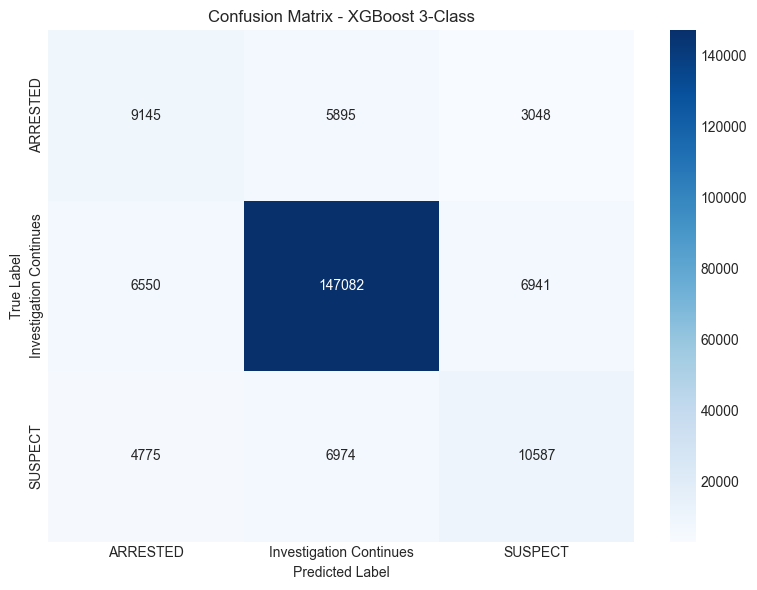


TRAINING: Random Forest (3-Class)
Training time: 49.15 seconds

EVALUATION: Random Forest 3-Class

Metrics:
  accuracy: 0.8165
  f1_macro: 0.5958
  f1_weighted: 0.8163
  precision_macro: 0.5969
  recall_macro: 0.5965

Classification Report:
                         precision    recall  f1-score   support

               ARRESTED       0.40      0.45      0.43     18088
Investigation Continues       0.91      0.91      0.91    160573
                SUSPECT       0.48      0.43      0.45     22336

               accuracy                           0.82    200997
              macro avg       0.60      0.60      0.60    200997
           weighted avg       0.82      0.82      0.82    200997



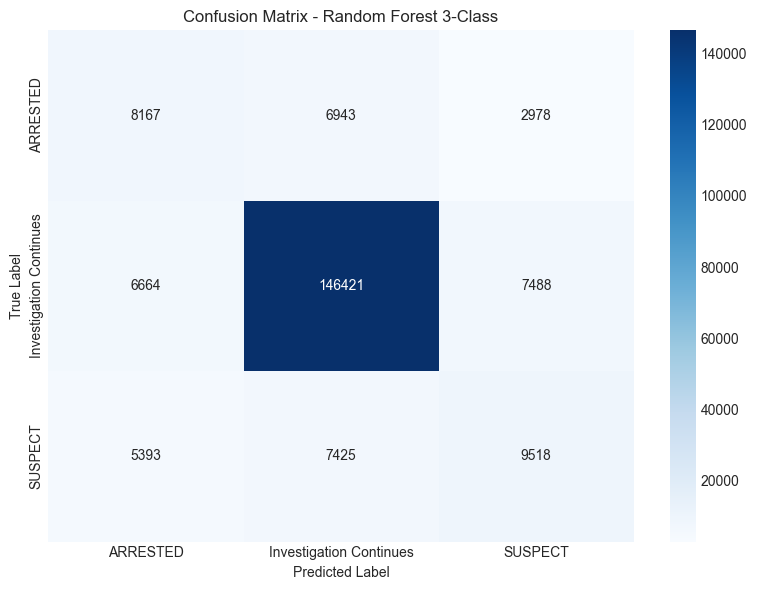


3-CLASS MODEL COMPARISON
       Model  Accuracy  F1 Macro  Precision   Recall  Train Time (s)
     XGBoost  0.829933  0.628513   0.626942 0.631851       62.038691
RandomForest  0.816460  0.595802   0.596916 0.596503       49.154453


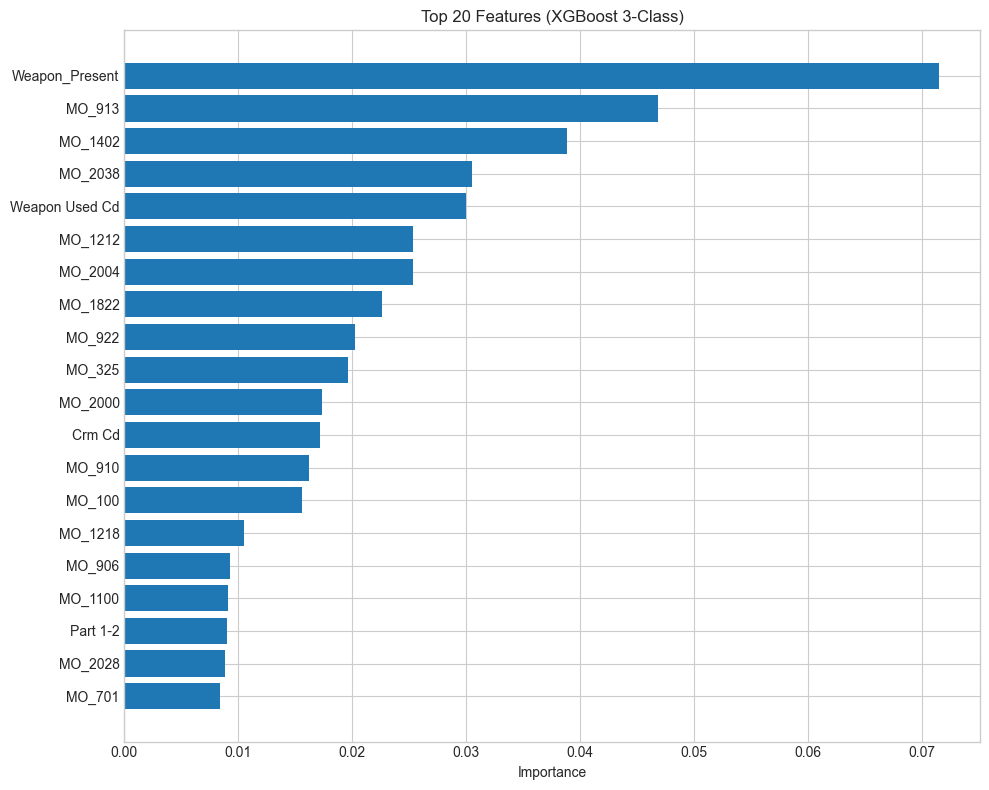

,feature,importance
131,Weapon_Present,0.071520
11,MO_913,0.046822
17,MO_1402,0.038888
36,MO_2038,0.030504
6,Weapon Used Cd,0.029977
102,MO_1212,0.025366
18,MO_2004,0.025345
9,MO_1822,0.022631
60,MO_922,0.020201
20,MO_325,0.019643


In [ ]:

# Step 2: Three-Class Classification
print("\n" + "=" * 80)
print("PHASE 1: THREE-CLASS CLASSIFICATION")
print("(ARRESTED vs SUSPECT vs Investigation Continues)")
print("=" * 80)
print("\nNOTE: This approach shows poor results due to class imbalance.")



three_class_results, three_class_summary = three_class.train_all_models(X_train, y_train, X_test, y_test)
three_class.get_feature_importance(X_train.columns, model_name='XGBoost')



PHASE 2: BINARY CLASSIFICATION
(IC vs NOT-IC)

Binary Class Distribution:
0 = IC (Investigation Continues)
1 = NOT-IC (ARRESTED or SUSPECT)
0    0.79888
1    0.20112
Name: proportion, dtype: float64

K-FOLD CROSS-VALIDATION (k=5)

Evaluating XGBoost...
  F1 Macro: 0.7790 (+/- 0.0011)

Evaluating LightGBM...
  F1 Macro: 0.7739 (+/- 0.0014)

Evaluating RandomForest...
  F1 Macro: 0.7113 (+/- 0.0046)

Evaluating LogisticRegression...
  F1 Macro: 0.6881 (+/- 0.0144)

Evaluating NaiveBayes...
  F1 Macro: 0.7033 (+/- 0.0016)


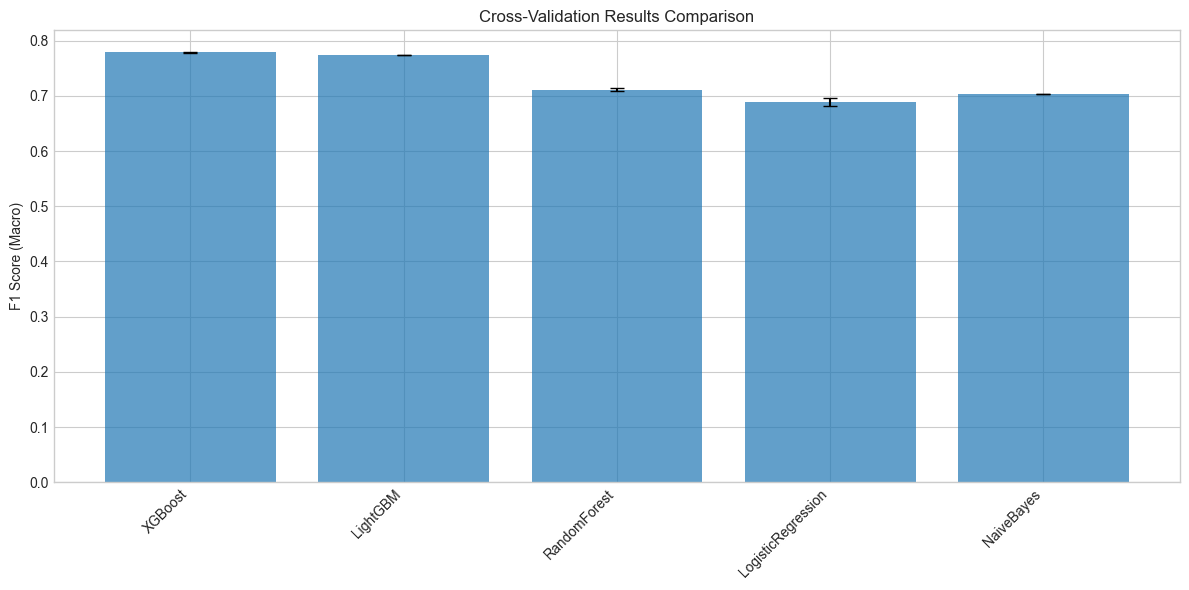


Cross-Validation Results Summary:
             Model  Mean F1   Std F1
           XGBoost 0.778960 0.000559
          LightGBM 0.773932 0.000712
      RandomForest 0.711280 0.002319
        NaiveBayes 0.703290 0.000792
LogisticRegression 0.688131 0.007207

Applying ADASYN resampling...
Original training size: 803987
Resampled training size: 1244198

MODEL 1: XGBoost (ADASYN + Balanced Weights)

EVALUATION: XGBoost

Metrics:
  accuracy: 0.8677
  f1_macro: 0.7845
  f1_weighted: 0.8645
  precision_macro: 0.7995
  recall_macro: 0.7722
  roc_auc: 0.8972

Classification Report:
              precision    recall  f1-score   support

          IC       0.91      0.93      0.92    160573
      NOT-IC       0.69      0.61      0.65     40424

    accuracy                           0.87    200997
   macro avg       0.80      0.77      0.78    200997
weighted avg       0.86      0.87      0.86    200997



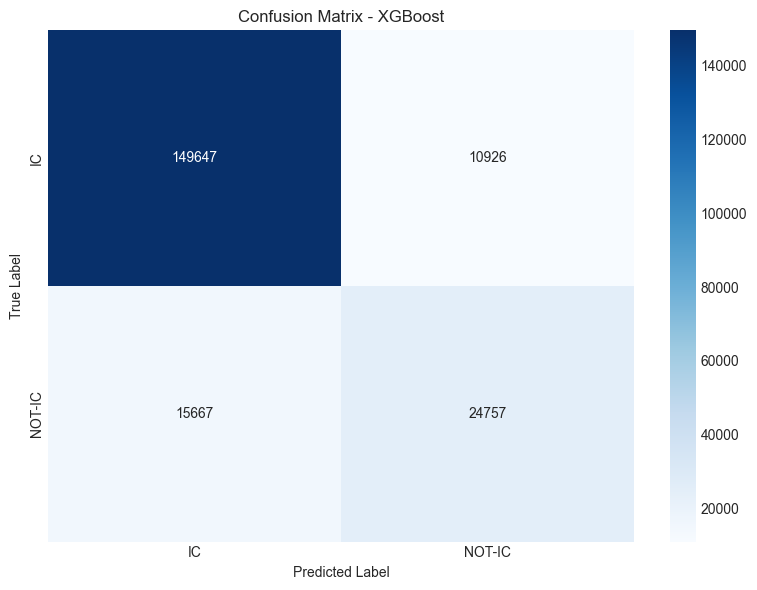


HYPERPARAMETER TUNING
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best parameters: {'subsample': 0.8, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.15, 'colsample_bytree': 0.9}
Best CV F1 Score: 0.9111

EVALUATION: XGBoost Tuned

Metrics:
  accuracy: 0.8678
  f1_macro: 0.7829
  f1_weighted: 0.8641
  precision_macro: 0.8010
  recall_macro: 0.7687
  roc_auc: 0.8939

Classification Report:
              precision    recall  f1-score   support

          IC       0.90      0.93      0.92    160573
      NOT-IC       0.70      0.60      0.65     40424

    accuracy                           0.87    200997
   macro avg       0.80      0.77      0.78    200997
weighted avg       0.86      0.87      0.86    200997



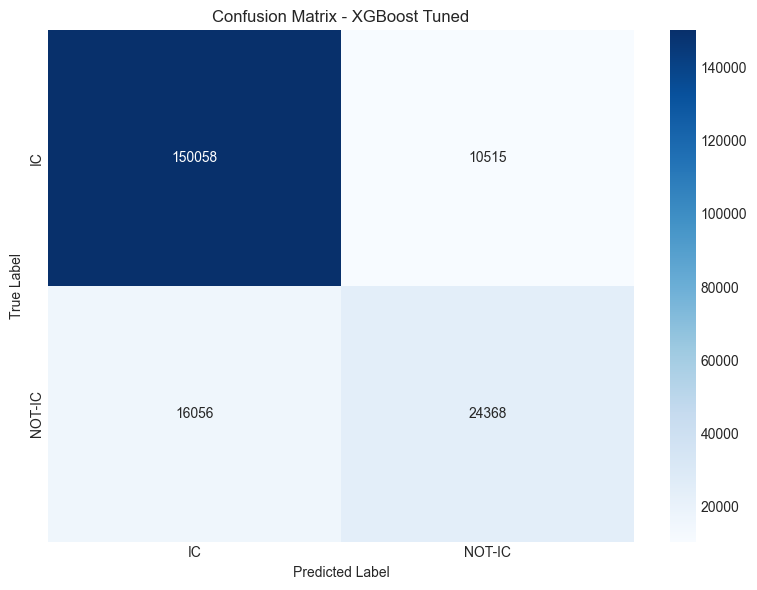


THRESHOLD TUNING


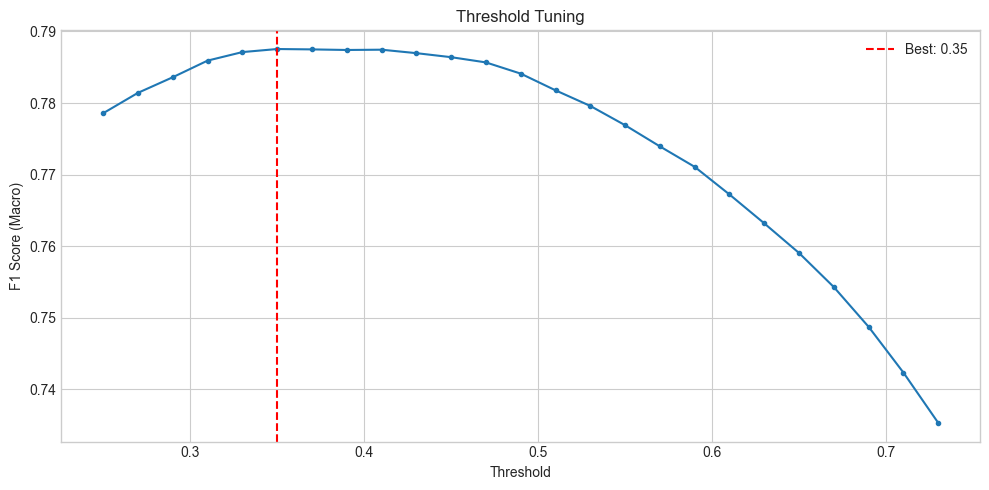

Optimal threshold: 0.35
F1 at optimal threshold: 0.7875

XGBoost with Tuned Threshold:
              precision    recall  f1-score   support

          IC       0.92      0.90      0.91    160573
      NOT-IC       0.64      0.70      0.66     40424

    accuracy                           0.86    200997
   macro avg       0.78      0.80      0.79    200997
weighted avg       0.86      0.86      0.86    200997


MODEL 3: LightGBM

EVALUATION: LightGBM

Metrics:
  accuracy: 0.8633
  f1_macro: 0.7782
  f1_weighted: 0.8603
  precision_macro: 0.7916
  recall_macro: 0.7670
  roc_auc: 0.8919

Classification Report:
              precision    recall  f1-score   support

          IC       0.90      0.93      0.92    160573
      NOT-IC       0.68      0.61      0.64     40424

    accuracy                           0.86    200997
   macro avg       0.79      0.77      0.78    200997
weighted avg       0.86      0.86      0.86    200997



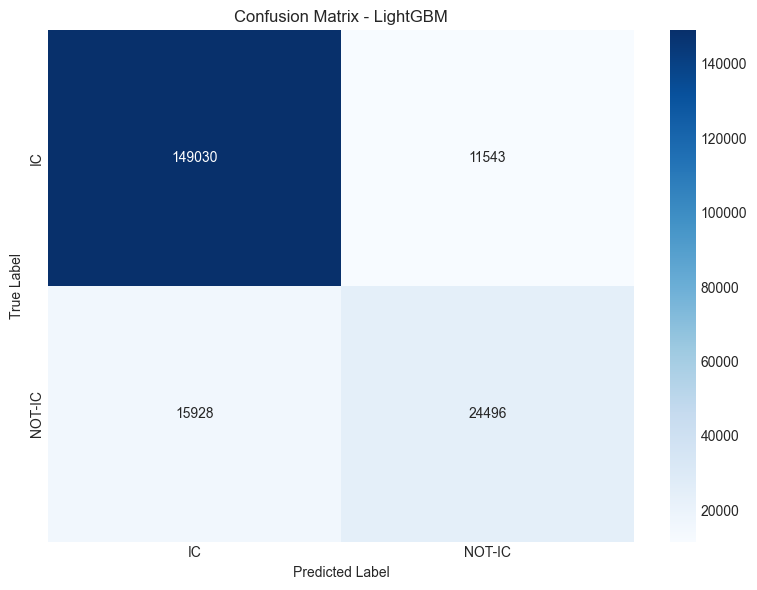


MODEL 4: CatBoost

EVALUATION: CatBoost

Metrics:
  accuracy: 0.8641
  f1_macro: 0.7795
  f1_weighted: 0.8612
  precision_macro: 0.7929
  recall_macro: 0.7684
  roc_auc: 0.8909

Classification Report:
              precision    recall  f1-score   support

          IC       0.90      0.93      0.92    160573
      NOT-IC       0.68      0.61      0.64     40424

    accuracy                           0.86    200997
   macro avg       0.79      0.77      0.78    200997
weighted avg       0.86      0.86      0.86    200997



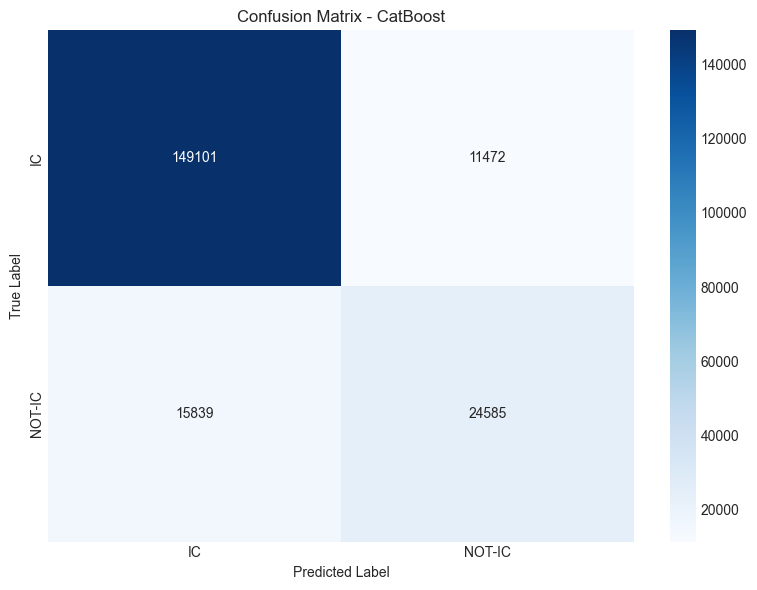


MODEL 5: Logistic Regression

EVALUATION: Logistic Regression

Metrics:
  accuracy: 0.7758
  f1_macro: 0.6835
  f1_weighted: 0.7857
  precision_macro: 0.6715
  recall_macro: 0.7048
  roc_auc: 0.7655

Classification Report:
              precision    recall  f1-score   support

          IC       0.89      0.82      0.85    160573
      NOT-IC       0.46      0.59      0.51     40424

    accuracy                           0.78    200997
   macro avg       0.67      0.70      0.68    200997
weighted avg       0.80      0.78      0.79    200997



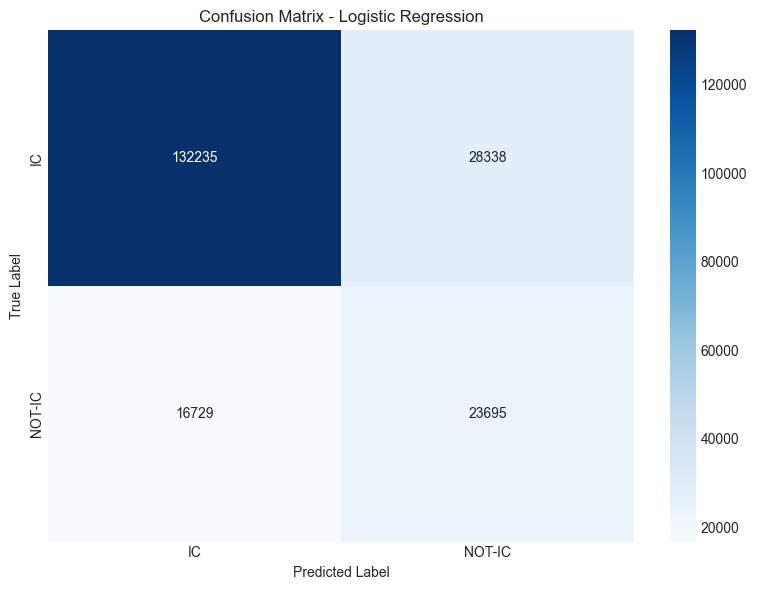


MODEL 6: Bernoulli Naive Bayes

EVALUATION: Naive Bayes

Metrics:
  accuracy: 0.7761
  f1_macro: 0.7069
  f1_weighted: 0.7920
  precision_macro: 0.6910
  recall_macro: 0.7557
  roc_auc: 0.8197

Classification Report:
              precision    recall  f1-score   support

          IC       0.92      0.79      0.85    160573
      NOT-IC       0.46      0.72      0.56     40424

    accuracy                           0.78    200997
   macro avg       0.69      0.76      0.71    200997
weighted avg       0.83      0.78      0.79    200997



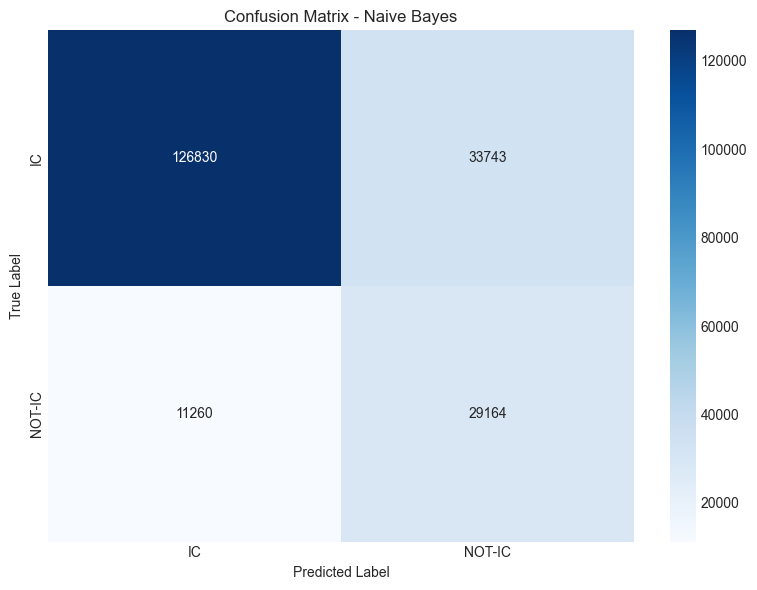


MODEL COMPARISON SUMMARY (Without PCA)
             Model  Accuracy  F1 Macro  Precision   Recall
           XGBoost  0.867695  0.784491   0.799516 0.772195
     XGBoost_Tuned  0.867804  0.782915   0.800954 0.768663
          CatBoost  0.864122  0.779502   0.792904 0.768367
          LightGBM  0.863326  0.778170   0.791575 0.767045
        NaiveBayes  0.776101  0.706898   0.691032 0.755656
LogisticRegression  0.775783  0.683484   0.671541 0.704841

BINARY CLASSIFICATION WITH PCA
Original features: 151
PCA components (95% variance): 125


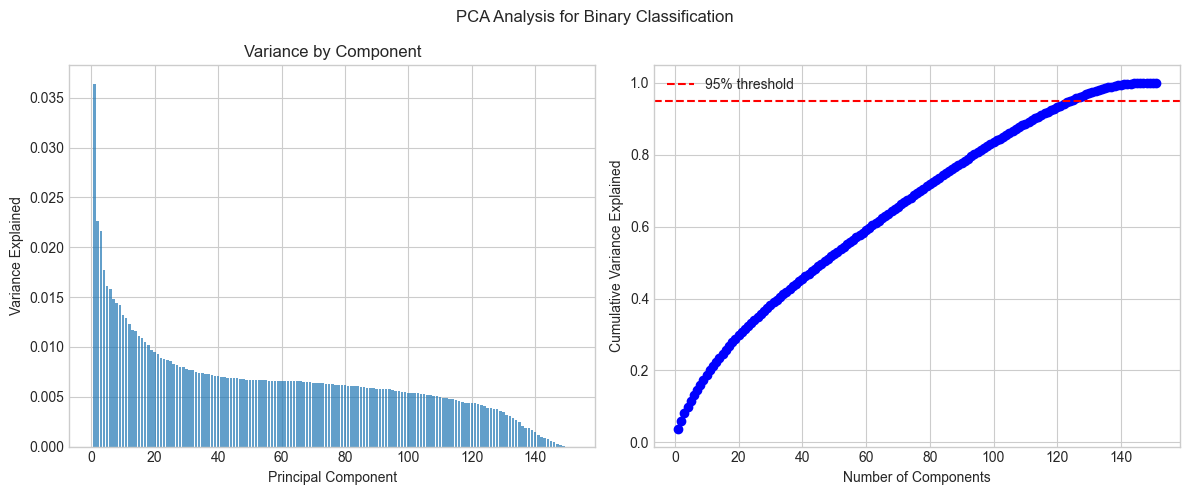


MODEL: XGBoost with PCA

EVALUATION: XGBoost with PCA

Metrics:
  accuracy: 0.8407
  f1_macro: 0.7525
  f1_weighted: 0.8408
  precision_macro: 0.7521
  recall_macro: 0.7530
  roc_auc: 0.8611

Classification Report:
              precision    recall  f1-score   support

          IC       0.90      0.90      0.90    160573
      NOT-IC       0.60      0.61      0.60     40424

    accuracy                           0.84    200997
   macro avg       0.75      0.75      0.75    200997
weighted avg       0.84      0.84      0.84    200997



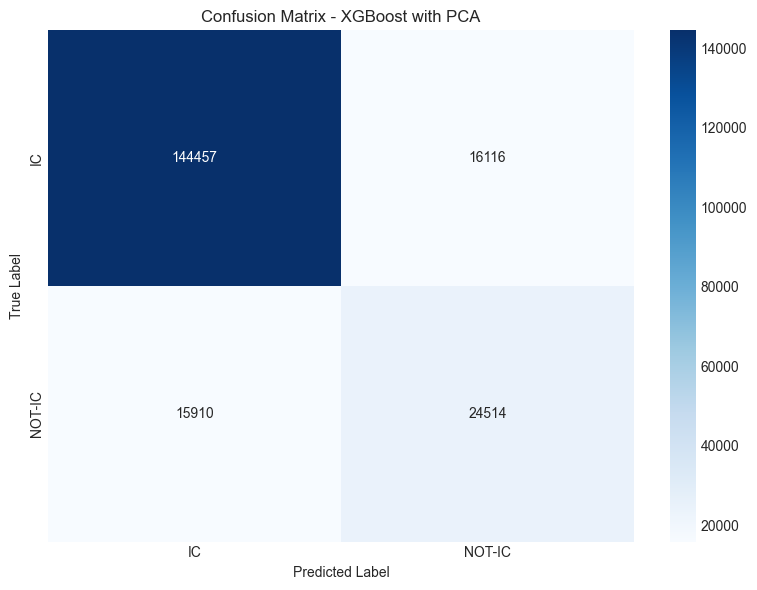


MODEL: LightGBM with PCA

EVALUATION: LightGBM with PCA

Metrics:
  accuracy: 0.8309
  f1_macro: 0.7479
  f1_weighted: 0.8344
  precision_macro: 0.7387
  recall_macro: 0.7591
  roc_auc: 0.8559

Classification Report:
              precision    recall  f1-score   support

          IC       0.91      0.88      0.89    160573
      NOT-IC       0.57      0.64      0.60     40424

    accuracy                           0.83    200997
   macro avg       0.74      0.76      0.75    200997
weighted avg       0.84      0.83      0.83    200997



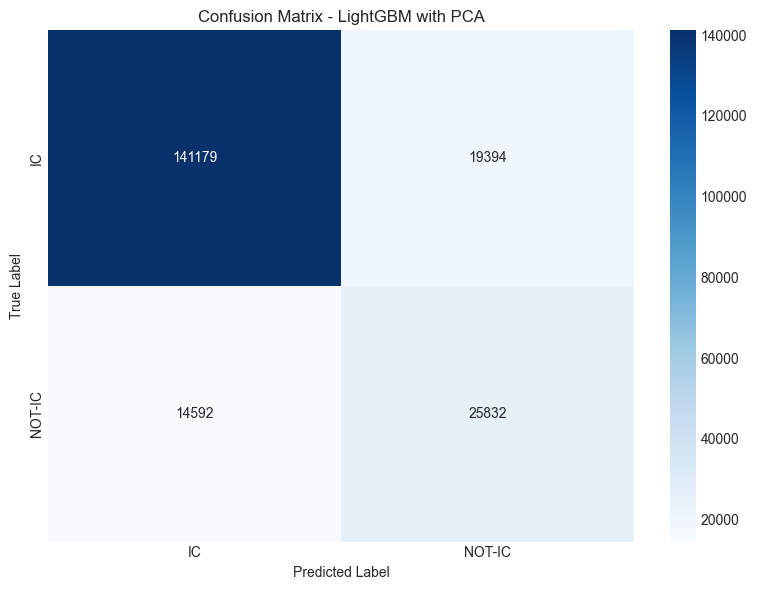


MODEL: Logistic Regression with PCA

EVALUATION: Logistic Regression with PCA

Metrics:
  accuracy: 0.7930
  f1_macro: 0.7019
  f1_weighted: 0.8004
  precision_macro: 0.6903
  recall_macro: 0.7198
  roc_auc: 0.7971

Classification Report:
              precision    recall  f1-score   support

          IC       0.89      0.84      0.87    160573
      NOT-IC       0.49      0.60      0.54     40424

    accuracy                           0.79    200997
   macro avg       0.69      0.72      0.70    200997
weighted avg       0.81      0.79      0.80    200997



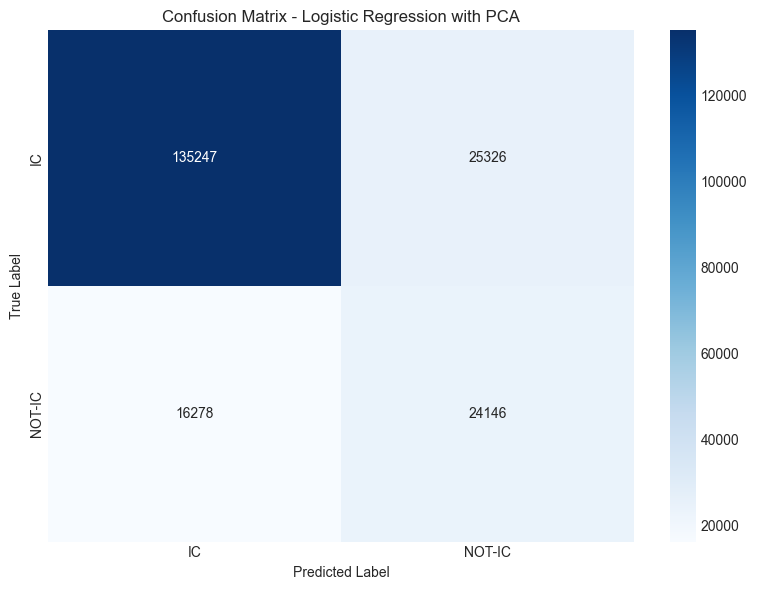


MODEL: CatBoost with PCA

EVALUATION: CatBoost with PCA

Metrics:
  accuracy: 0.8283
  f1_macro: 0.7454
  f1_weighted: 0.8323
  precision_macro: 0.7354
  recall_macro: 0.7581
  roc_auc: 0.8528

Classification Report:
              precision    recall  f1-score   support

          IC       0.91      0.88      0.89    160573
      NOT-IC       0.56      0.64      0.60     40424

    accuracy                           0.83    200997
   macro avg       0.74      0.76      0.75    200997
weighted avg       0.84      0.83      0.83    200997



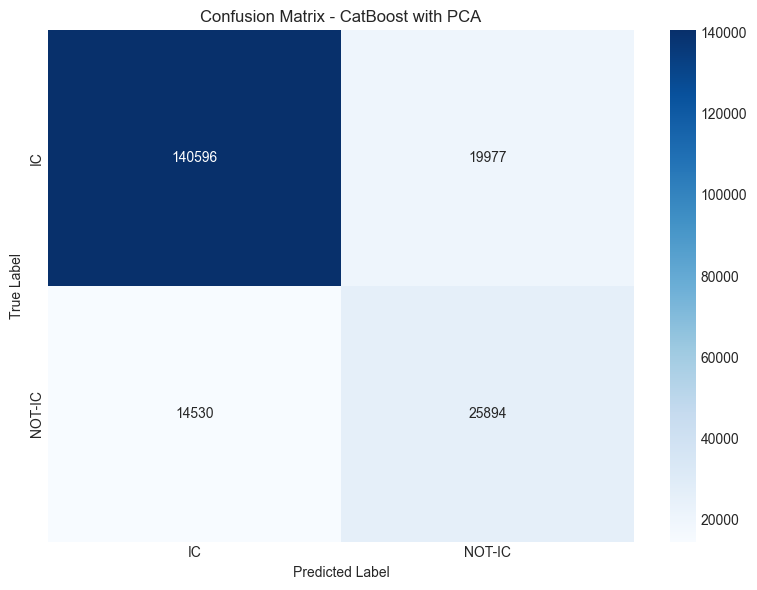


MODEL COMPARISON SUMMARY (With PCA)
                 Model  Accuracy  F1 Macro  Precision   Recall  Features
           XGBoost_PCA  0.840664  0.752546   0.752069 0.753028       125
          LightGBM_PCA  0.830913  0.747883   0.738750 0.759123       125
          CatBoost_PCA  0.828321  0.745412   0.735415 0.758075       125
LogisticRegression_PCA  0.793012  0.701947   0.690323 0.719798       125


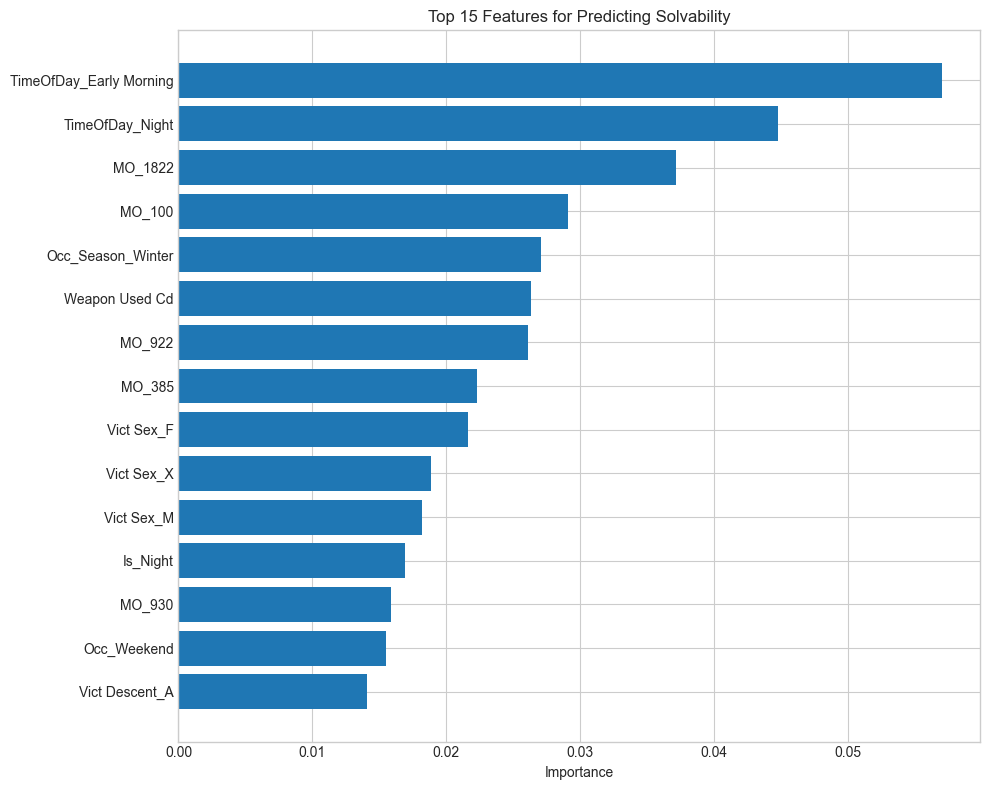


Top 15 Features for Predicting Solvability:
                feature  importance
TimeOfDay_Early Morning    0.056993
        TimeOfDay_Night    0.044787
                MO_1822    0.037134
                 MO_100    0.029091
      Occ_Season_Winter    0.027082
         Weapon Used Cd    0.026336
                 MO_922    0.026118
                 MO_385    0.022262
             Vict Sex_F    0.021646
             Vict Sex_X    0.018874
             Vict Sex_M    0.018176
               Is_Night    0.016917
                 MO_930    0.015898
            Occ_Weekend    0.015490
         Vict Descent_A    0.014049

COMPREHENSIVE RESULTS COMPARISON

All Models Ranked by F1 Macro Score:
                 Model   Approach  Accuracy  F1 Macro  Precision   Recall
               XGBoost     Binary  0.867695  0.784491   0.799516 0.772195
         XGBoost_Tuned     Binary  0.867804  0.782915   0.800954 0.768663
              CatBoost     Binary  0.864122  0.779502   0.792904 0.768367
           

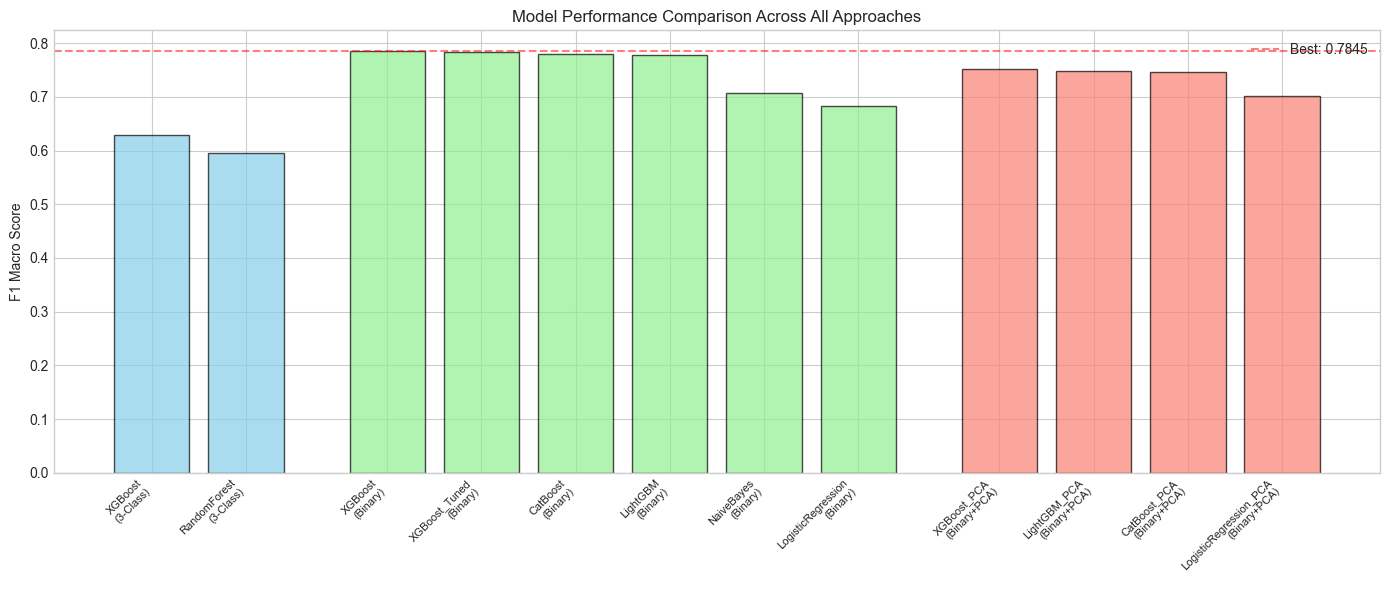


FINAL SUMMARY

1. THREE-CLASS CLASSIFICATION:
   - Best model: XGBoost
   - Best F1 Macro: 0.6285

2. BINARY CLASSIFICATION (IC vs NOT-IC):
   - Best model: XGBoost
   - Best F1 Macro: 0.7845

3. BINARY CLASSIFICATION WITH PCA:
   - Reduced from 151 to 125 features
   - Best model: XGBoost_PCA
   - Best F1 Macro: 0.7525

4. PCA IMPACT: Reduced by 0.0319

5. TOP PREDICTIVE FEATURES:
   - TimeOfDay_Early Morning: 0.0570
   - TimeOfDay_Night: 0.0448
   - MO_1822: 0.0371
   - MO_100: 0.0291
   - Occ_Season_Winter: 0.0271


In [12]:

# Step 3: Binary Classification
print("\n" + "=" * 80)
print("PHASE 2: BINARY CLASSIFICATION")
print("(IC vs NOT-IC)")
print("=" * 80)

binary_clf = BinaryClassifier(config)
X_binary, y_binary = binary_clf.prepare_data(df, X, y)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_binary, y_binary, test_size=config.TEST_SIZE,
    random_state=config.RANDOM_STATE, stratify=y_binary
)

# Step 4: Cross-Validation
models_for_cv = {
    'XGBoost': XGBClassifier(n_estimators=300, max_depth=8, learning_rate=0.1,
                                random_state=config.RANDOM_STATE, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(n_estimators=300, max_depth=8, learning_rate=0.1,
                                    random_state=config.RANDOM_STATE, verbose=-1),
    'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=10,
                                            random_state=config.RANDOM_STATE, n_jobs=-1),
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=config.RANDOM_STATE),
    'NaiveBayes': BernoulliNB()
}

cv_results_df, cv_results = binary_clf.cross_validate_models(X_train_bin, y_train_bin, models_for_cv)

# Step 5: Full Model Training
model_results, binary_summary, X_train_res, y_train_res, sample_weights = binary_clf.train_all_models(
    X_train_bin, y_train_bin, X_test_bin, y_test_bin
)

# Step 6: PCA Feature Reduction
pca_results, pca_summary, n_pca_components = binary_clf.train_models_with_pca(
    X_train_bin, y_train_bin, X_test_bin, y_test_bin,
    X_train_res, y_train_res, sample_weights
)

# Step 7: Feature Importance
importance_df = binary_clf.get_feature_importance(X_train_bin.columns)

# Step 8: Comprehensive Comparison
all_results = compare_all_results(three_class_summary, binary_summary, pca_summary)

# Final Summary
print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print("\n1. THREE-CLASS CLASSIFICATION:")
print(f"   - Best model: {three_class_summary.iloc[0]['Model']}")
print(f"   - Best F1 Macro: {three_class_summary.iloc[0]['F1 Macro']:.4f}")

print("\n2. BINARY CLASSIFICATION (IC vs NOT-IC):")
print(f"   - Best model: {binary_summary.iloc[0]['Model']}")
print(f"   - Best F1 Macro: {binary_summary.iloc[0]['F1 Macro']:.4f}")

print("\n3. BINARY CLASSIFICATION WITH PCA:")
print(f"   - Reduced from {X_train_bin.shape[1]} to {n_pca_components} features")
print(f"   - Best model: {pca_summary.iloc[0]['Model']}")
print(f"   - Best F1 Macro: {pca_summary.iloc[0]['F1 Macro']:.4f}")

best_no_pca = binary_summary.iloc[0]['F1 Macro']
best_with_pca = pca_summary.iloc[0]['F1 Macro']
pca_diff = best_with_pca - best_no_pca

print(f"\n4. PCA IMPACT: {'Improved' if pca_diff > 0 else 'Reduced'} by {abs(pca_diff):.4f}")

print("\n5. TOP PREDICTIVE FEATURES:")
for _, row in importance_df.head(5).iterrows():
    print(f"   - {row['feature']}: {row['importance']:.4f}")


In [13]:

best_overall = all_results.iloc[0]
print(f"\n6. OVERALL BEST: {best_overall['Model']} ({best_overall['Approach']}) - F1: {best_overall['F1 Macro']:.4f}")



6. OVERALL BEST: XGBoost (Binary) - F1: 0.7845
